Dataset Loaded Successfully!
   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2       4  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   
3       6  CA-2014-115812    6/9/2014   6/14/2014  Standard Class    BH-11710   
4      11  CA-2014-115812    6/9/2014   6/14/2014  Standard Class    BH-11710   

     Customer Name   Segment        Country             City  ... Postal Code  \
0      Claire Gute  Consumer  United States        Henderson  ...       42420   
1      Claire Gute  Consumer  United States        Henderson  ...       42420   
2   Sean O'Donnell  Consumer  United States  Fort Lauderdale  ...       33311   
3  Brosina Hoffman  Consumer  United States      Los Angeles  ...       90032   
4  Brosina Hoffman  Consumer  United States      Los Angeles  ...       90032  

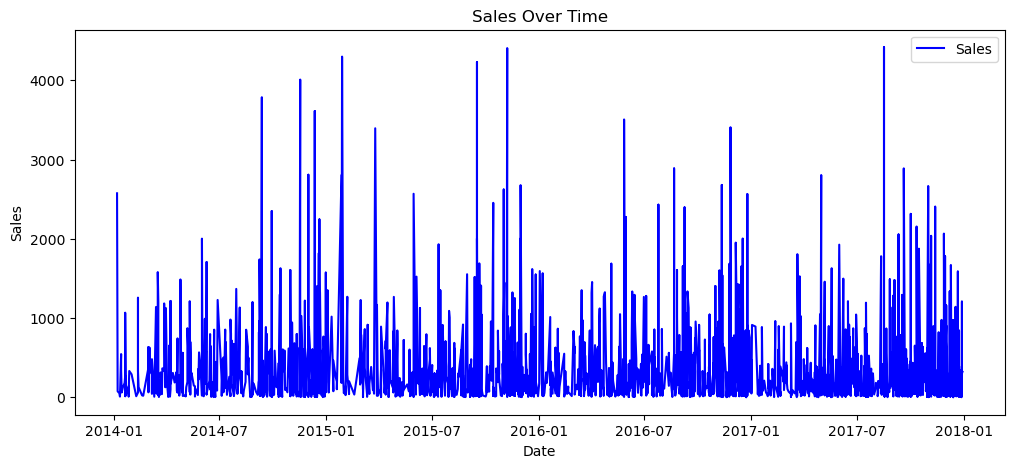

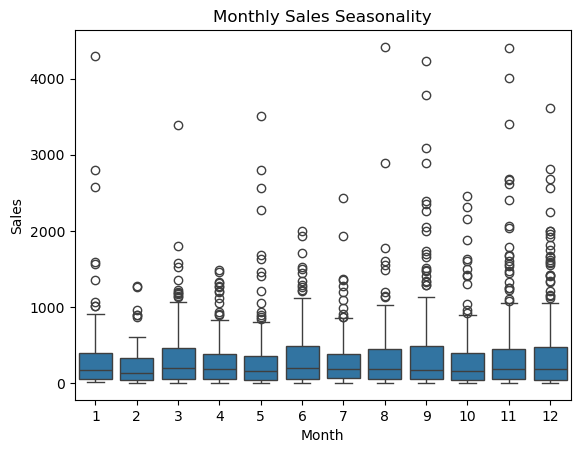

Training samples: 2031, Testing samples: 90

 Model Fitted Successfully!
                                     SARIMAX Results                                      
Dep. Variable:                              sales   No. Observations:                 2031
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -15469.850
Date:                            Mon, 27 Oct 2025   AIC                          30951.700
Time:                                    16:06:49   BIC                          30985.359
Sample:                                         0   HQIC                         30964.054
                                           - 2031                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
promotion   -168.6737     74.435     -2.2

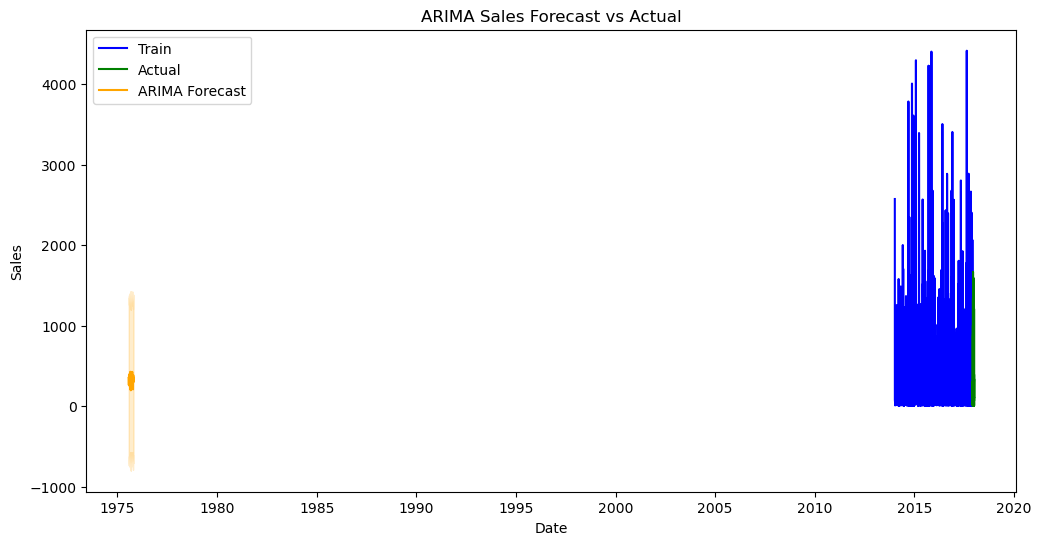


 Model Performance:
MAE  = 280.18
RMSE = 362.97


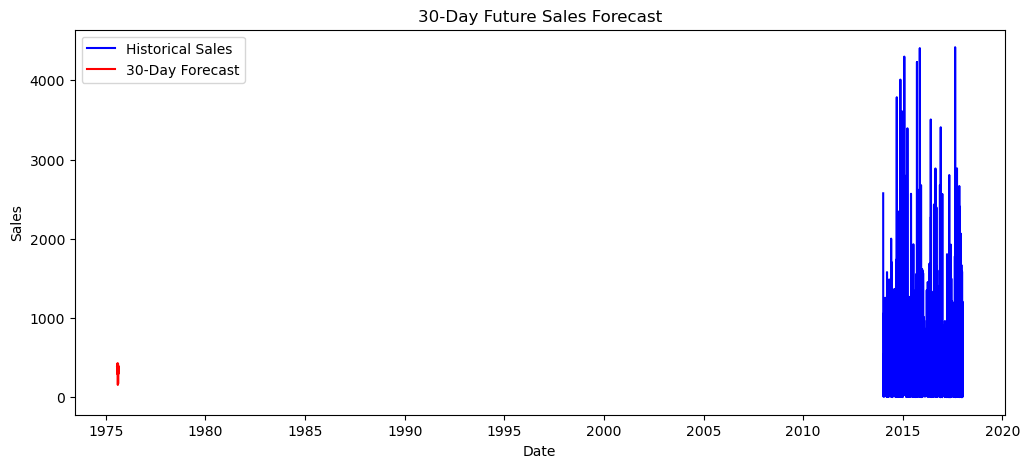


 Forecasting Completed Successfully!


In [6]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Step 2: Load Dataset
df = pd.read_csv("Downloads/stores_sales_forecasting/stores_sales_forecasting.csv", encoding='latin1')

print("Dataset Loaded Successfully!")
print(df.head())
print("\nColumns:", list(df.columns))

# Step 3: Identify Columns Automatically
# Try to detect date and sales columns
date_col = [c for c in df.columns if 'date' in c.lower()][0]
sales_col = [c for c in df.columns if 'sale' in c.lower()][0]

# Optional: detect promotion-like column
promo_cols = [c for c in df.columns if 'promo' in c.lower() or 'discount' in c.lower() or 'holiday' in c.lower()]
promo_col = promo_cols[0] if promo_cols else None

# Convert and clean
df[date_col] = pd.to_datetime(df[date_col])
df = df.sort_values(date_col)
df = df[[date_col, sales_col] + ([promo_col] if promo_col else [])]

# Rename columns
df.rename(columns={date_col: 'date', sales_col: 'sales'}, inplace=True)
if promo_col:
    df.rename(columns={promo_col: 'promotion'}, inplace=True)
else:
    df['promotion'] = 0  # if no promo column exists

df.set_index('date', inplace=True)

print("\n Cleaned Data Preview:")
print(df.head())

# Step 4: Visualize Sales Trends
plt.figure(figsize=(12, 5))
plt.plot(df['sales'], label='Sales', color='blue')
plt.title("Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

# Optional: Monthly pattern
sns.boxplot(x=df.index.month, y=df['sales'])
plt.title("Monthly Sales Seasonality")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.show()

# Step 5: Split Train/Test
train = df.iloc[:-90]
test = df.iloc[-90:]

print(f"Training samples: {len(train)}, Testing samples: {len(test)}")

# Step 6: Fit SARIMAX Model
model = SARIMAX(
    train['sales'],
    order=(1, 1, 1),               # ARIMA(p,d,q)
    seasonal_order=(1, 1, 1, 12),  # Seasonal part (P,D,Q,s)
    exog=train[['promotion']]
)
results = model.fit()

print("\n Model Fitted Successfully!")
print(results.summary())

# Step 7: Forecast Future Sales
forecast_obj = results.get_forecast(steps=len(test), exog=test[['promotion']])
forecast_mean = forecast_obj.predicted_mean
conf_int = forecast_obj.conf_int()

# Step 8: Plot Forecast vs Actual
plt.figure(figsize=(12, 6))
plt.plot(train['sales'], label='Train', color='blue')
plt.plot(test['sales'], label='Actual', color='green')
plt.plot(forecast_mean, label='ARIMA Forecast', color='orange')

plt.fill_between(conf_int.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='orange', alpha=0.2)

plt.title("ARIMA Sales Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

# Step 9: Evaluate Model Performance
mae = mean_absolute_error(test['sales'], forecast_mean)
rmse = np.sqrt(mean_squared_error(test['sales'], forecast_mean))

print(f"\n Model Performance:")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")

# Step 10: Future Forecast (Next 30 Days)
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
future_exog = pd.DataFrame({'promotion': np.random.choice([0, 1], size=len(future_dates), p=[0.85, 0.15])}, index=future_dates)

future_forecast = results.get_forecast(steps=30, exog=future_exog)
future_sales = future_forecast.predicted_mean

plt.figure(figsize=(12, 5))
plt.plot(df['sales'], label='Historical Sales', color='blue')
plt.plot(future_sales, label='30-Day Forecast', color='red')
plt.title("30-Day Future Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

print("\n Forecasting Completed Successfully!")
